<a href="https://colab.research.google.com/github/sbmoyano/data_science_projects/blob/master/fraud_detection/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I intend to perform and exploration of the data available, as well as to try to understand which features could offer interesting insights that would help to classify fraud and non-fraud transactions.

I will also split the dataset into train, test and validation sets, so they are ready to be used for feature engineering and model training in the next notebooks.

In [ ]:
# install if running from Colab
! pip install opendatasets
! pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 39.2 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=66c651523e86b4e16f6333b92048a1a84e90a4ee3f03edde470accb752d3a198
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=7790e358e4aa329a6423367fbd44a64da30553488a7601eec2ff3ac8b975eb42
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.

# Set environment

In [ ]:
# Manage paths
import sys

# Data manipulation
import pandas as pd
import numpy as np
import os
import opendatasets
from datetime import datetime, timedelta
import pingouin as pg
from collections import Counter

# Visualization
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster, HeatMap

# custom transformers
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Paths

Get data from Kaggle using its API. I will load the data into a pandas DataFrame to work with it, and save it as a csv file to a local folder in Google Drive.

In [ ]:
# connect to GoogleDrive on Colab to import stored data there
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path for Colab
sys.path.append("drive/MyDrive/GITHUB/data_science_projects/fraud_detection/")

# path to import pandas and Numpy files
root_path_gd = os.getcwd()
data_path_gd = os.path.join(os.getcwd(), ".data/.processed/")

In [ ]:
# root path and paths to useful folders
root_path_gd = "drive/MyDrive/GITHUB/data_science_projects/fraud_detection/"
data_dir = os.path.join(root_path_gd, ".data")
data_raw_dir = os.path.join(root_path_gd, ".data/.raw")
data_processed_dir = os.path.join(root_path_gd, ".data/.processed")

# create directories if they do not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(data_raw_dir):
    os.makedirs(data_raw_dir)
if not os.path.exists(data_processed_dir):
    os.makedirs(data_processed_dir)

# Import data

In [ ]:
# Jupyter Notebook
opendatasets.download("https://www.kaggle.com/datasets/kartik2112/fraud-detection")

Skipping, found downloaded files in "./fraud-detection" (use force=True to force download)


In [ ]:
df_train = pd.read_csv("/content/fraud-detection/fraudTrain.csv", index_col=0)
df_test = pd.read_csv("/content/fraud-detection/fraudTest.csv", index_col=0)

## Check DataFrames

In both DataFrames have the same number of columns. Also, the last column 'is_fraud' seem to be our target variable to be predicted, so I will split the DataFrame into X and y considering this.

In [ ]:
display(df_train.head())
display(df_test.head())

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
print("Columns information of the train dataset:\n")
print(df_train.info())
print("\nColumns information of the test dataset:\n")
print(df_test.info())

Columns information of the train dataset:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   129667

### Do all merchant names contain the string 'fraud'?

From the DataFrames it seems that by default all merchant names contain the string 'fraud', and not only those merchants involved in fraud transactions. As this is useless, I will remove it from merchant's names.

In [ ]:
num_str_fraud = df_train["merchant"].str.contains("fraud").sum()
length_df = len(df_train)

print("{} 'merchant' names in train DataFrame contains the word 'fraud' from {} rows in the DataFrame".format(num_str_fraud, length_df))

1296675 'merchant' names in train DataFrame contains the word 'fraud' from 1296675 rows in the DataFrame


### Basic preprocessing steps

Let's create some Custom Transformers using Sklearn to do all these basic preprocessing steps (i.e., transform columns to datetime, remove unnecessary strings, etc.) in a Pipeline, which will be faster than calling all functions.

In [ ]:
class ColumnsToDatetime(TransformerMixin):
    
    def __init__(self, cols_names):
        super().__init__()
        self.columns = cols_names
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        print("Transforming selected columns to datetime")
        
        for col in self.columns:
            X[col] = pd.to_datetime(X[col])
    
        # compute age of each person
        X["age"] = X["trans_date_trans_time"].dt.year - X["dob"].dt.year
        X["hour"] = X["trans_date_trans_time"].dt.hour
        X["total_seconds_day"] = X["trans_date_trans_time"].apply(
            lambda x: timedelta(hours=x.hour, minutes=x.minute, 
                                seconds=x.second)).dt.total_seconds()
        X["month"] = X["trans_date_trans_time"].dt.month
        X["day"] = X["trans_date_trans_time"].dt.day
        X["year"] = X["trans_date_trans_time"].dt.year
        
        return X

    
class RemoveString(TransformerMixin):
    
    def __init__(self, dict_cols_str):
        super().__init__()
        self.cols_str = dict_cols_str
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        print("Removing undesired strings")
        
        for col, string in self.cols_str.items():
                
            X[col] = X[col].map(lambda x: x.lstrip(string))
    
        return X

    
class SetAgeCohort(TransformerMixin):
    
    def __init__(self, dict_cohorts, age_col_name):
        super().__init__()
        self.age_col = age_col_name
        self.cohorts = dict_cohorts
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        print("Setting age cohort for each cardholder")
        
        X["cohort"] = 0
        for cohort, age_interval in self.cohorts.items():
            
            age_cond = (X[self.age_col] >= age_interval[0]) & (X[self.age_col] < age_interval[1])

            X.loc[age_cond, "cohort"] = cohort

        return X
    

class TextToLowercase(TransformerMixin):
    
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        print("Setting text in each column to lowercase")
        
        for col in list(X.columns):
            if X[col].dtype == "O":
                X[col] = X[col].str.lower()

        return X

In [ ]:
age_groups = {"10-20": [10, 20], "20-30": [20, 30], "30-40": [30, 40], 
              "40-50": [40, 50], "50-60": [50, 60], "60-70": [60, 70],
              "70-80": [70, 80], "80-90": [80, 90], "90-100": [90, 100]}


preprocessing_pipe = Pipeline([("to_datetime", ColumnsToDatetime(cols_names=["trans_date_trans_time", "dob"])),
                               ("remove_strings", RemoveString(dict_cols_str={"merchant": "fraud_"})),
                               ("set_cohorts", SetAgeCohort(dict_cohorts=age_groups, age_col_name="age")),
                               ("to_lowercase", TextToLowercase())])

In [ ]:
df_train = preprocessing_pipe.fit_transform(df_train)

Transforming selected columns to datetime
Removing undesired strings
Setting age cohort for each cardholder
Setting text in each column to lowercase


In [ ]:
df_test = preprocessing_pipe.transform(df_test)

Transforming selected columns to datetime
Removing undesired strings
Setting age cohort for each cardholder
Setting text in each column to lowercase


### Explore columns data types and null values

#### First, which data is going to be used to train and test the model?

First, following this dataset already splitted in train and test, I will train our model in past data from 2019 to 2020, while testing it in more recent data from 2020.

I can also see that the most recent date of the training set and the less recent of the test set are the same: 2020-06-21. I should explore if they contain duplicated data in the train an test set, which could lead to data leaking when I train the model.

In [ ]:
print("We will train our model with data from {} to {}".format(df_train["trans_date_trans_time"].dt.date.min(), 
                                                               df_train["trans_date_trans_time"].dt.date.max()))
print("We will be using test data from {} to {}".format(df_test["trans_date_trans_time"].dt.date.min(), 
                                                        df_test["trans_date_trans_time"].dt.date.max()))

We will train our model with data from 2019-01-01 to 2020-06-21
We will be using test data from 2020-06-21 to 2020-12-31


However, I can see that although the training and test set share a common date (2020-06-21), they do not contain duplicated date. The latest transaction in the training set took place at 12:13:37, while the most recent transaction in the test set took place at 12:14:25. Consequently, no data is shared between the train and test set.

In [ ]:
most_recent_trans_train = df_train[df_train["trans_date_trans_time"].dt.date == df_train["trans_date_trans_time"].dt.date.max()]["trans_date_trans_time"].dt.time.max()
less_recent_trans_test = df_test[df_test["trans_date_trans_time"].dt.date == df_test["trans_date_trans_time"].dt.date.min()]["trans_date_trans_time"].dt.time.min()

print("For the date 2020-06-21, the most recent date for the training set is {}, while for the test set is {}".format(most_recent_trans_train, less_recent_trans_test))

For the date 2020-06-21, the most recent date for the training set is 12:13:37, while for the test set is 12:14:25


### How many time points do I have to train and test the model?

I have 70 percent of all the data to train the model and 30% to test it. However, let's get a validation set. For this, instead of merging all the data back together, I am just going to split the train set. Again, 70% of the data from the train set will be used for training, while 30% of the train set will be used for validation.

The idea is to get the 70% of the oldest transactions to train the model, and the 30% most recent ones for validation.

In [ ]:
train_dates = df_train["trans_date_trans_time"]
test_dates = df_test["trans_date_trans_time"]

# how many time points do I have in the train and test sets?
print("We have {} ({}%) time points for training and {} ({}%) to test the model".format(len(train_dates), 
                                                                                        round((len(train_dates)/(len(train_dates) + len(test_dates)))*100, 2), 
                                                                                        len(test_dates), 
                                                                                        round((len(test_dates)/(len(train_dates) + len(test_dates)))*100, 2)))

# calculate how many days I have in the test set
total_days_train = (train_dates.max() - train_dates.min()).days
train_days = round(((total_days_train*70)/100))
val_days = round(((total_days_train*30)/100))
print("We have {} days in the train set. We will select {} for training and {} for validation".format(total_days_train, train_days, val_days))

We have 1296675 (70.0%) time points for training and 555719 (30.0%) to test the model
We have 537 days in the train set. We will select 376 for training and 161 for validation


In [ ]:
# substract 96 days from the maximum date in the test set
mean_date = df_train["trans_date_trans_time"].dt.date.max() - timedelta(days=161)

# split the original test set into validation and test sets
df_val = df_train[df_train["trans_date_trans_time"].dt.date > mean_date].reset_index(drop=True)
df_train = df_train[df_train["trans_date_trans_time"].dt.date < mean_date].reset_index(drop=True)

# print
print("Train data dates between {} and {}".format(df_train["trans_date_trans_time"].dt.date.min(), 
                                                  df_train["trans_date_trans_time"].dt.date.max()))
print("Validation data dates between {} and {}".format(df_val["trans_date_trans_time"].dt.date.min(), 
                                                       df_val["trans_date_trans_time"].dt.date.max()))
print("Test data dates between {} and {}".format(df_test["trans_date_trans_time"].dt.date.min(), 
                                                 df_test["trans_date_trans_time"].dt.date.max()))

Train data dates between 2019-01-01 and 2020-01-11
Validation data dates between 2020-01-13 and 2020-06-21
Test data dates between 2020-06-21 and 2020-12-31


In [ ]:
# print 
print("Number of days in the validation set: {}".format(
    df_train["trans_date_trans_time"].dt.date.nunique()))
print("Number of days in the validation set: {}".format(
    df_val["trans_date_trans_time"].dt.date.nunique()))
print("Number of days in the test set: {}".format(
    df_test["trans_date_trans_time"].dt.date.nunique()))

Number of days in the validation set: 376
Number of days in the validation set: 160
Number of days in the test set: 194


### What is our outcome?

Our outcome is binary, with 0 denoting fraud transactions and 1 the fraud ones. I can see that the unique values in the outcome of our dataset are 0 and 1.

In [ ]:
df_train["is_fraud"].unique()

array([0, 1])

## Save train, test and validation sets

In [ ]:
df_train.to_csv(os.path.join(data_processed_dir, "df_train.csv"))
df_test.to_csv(os.path.join(data_processed_dir, "df_test.csv"))
df_val.to_csv(os.path.join(data_processed_dir, "df_val.csv"))

## Import datasets

Check that all the columns have the correct type

In [ ]:
df_train = pd.read_csv(os.path.join(data_processed_dir, "df_train.csv"), index_col=0)
df_test = pd.read_csv(os.path.join(data_processed_dir, "df_test.csv"), index_col=0)
df_val = pd.read_csv(os.path.join(data_processed_dir, "df_val.csv"), index_col=0)

df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_val["trans_date_trans_time"] = pd.to_datetime(df_val["trans_date_trans_time"])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942980 entries, 0 to 942979
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  942980 non-null  datetime64[ns]
 1   cc_num                 942980 non-null  int64         
 2   merchant               942980 non-null  object        
 3   category               942980 non-null  object        
 4   amt                    942980 non-null  float64       
 5   first                  942980 non-null  object        
 6   last                   942980 non-null  object        
 7   gender                 942980 non-null  object        
 8   street                 942980 non-null  object        
 9   city                   942980 non-null  object        
 10  state                  942980 non-null  object        
 11  zip                    942980 non-null  int64         
 12  lat                    942980 non-null  floa

## How many fraud transactions do I have in the train, test and validation sets compared to non-fraud transactions?

The dataset is unbalanced, were only a 6% of the transactions of the training data are fraud. I will implement techniques to account for dataset imbalance when fitting the model or before fitting it.

In [ ]:
# count the number of transactions of each type in each dataset
train_trans_type = Counter(df_train["is_fraud"])
test_trans_type = Counter(df_test["is_fraud"])
val_trans_type = Counter(df_val["is_fraud"])

# total number of transactions in each dataset
total_trans_train = len(df_train)
total_trans_test = len(df_test)
total_trans_val = len(df_val)

# print
print("From a total of {} transactions in the train set, {} ({}%) of them are fraud".format(total_trans_train, 
                                                                                                 train_trans_type[1], 
                                                                                                 round((train_trans_type[1]/total_trans_train)*100, 2)))
print("From a total of {} transactions in the test set, {} ({}%) of them are fraud".format(total_trans_test, 
                                                                                                test_trans_type[1], 
                                                                                                round((test_trans_type[1]/total_trans_test)*100, 2)))
print("From a total of {} transactions in the validation set, {} ({}%) of them are fraud".format(total_trans_val, 
                                                                                                      val_trans_type[1], 
                                                                                                      round((val_trans_type[1]/total_trans_val)*100, 2)))


From a total of 942980 transactions in the train set, 5343 (0.57%) of them are fraudulent
From a total of 555719 transactions in the test set, 2145 (0.39%) of them are fraudulent
From a total of 351227 transactions in the validation set, 2139 (0.61%) of them are fraudulent


## Explore the data

### Number of unique categories

Column 'cc_num' gives an ID number for each cardholder in the dataset. Let's see how many unique cardholder I have in the train set, as well the number of fraud and non-fraud transactions. Let's also see how many unique merchant categories, job categories, cities and states I have.

In [ ]:
# extract data
n_cc = df_train["cc_num"].nunique()
date_min = df_train["trans_date_trans_time"].dt.date.min()
date_max = df_train["trans_date_trans_time"].dt.date.max()
n_trans_type = Counter(df_train["is_fraud"])

# print
print("In the training dataset we have a total of {} cardholders\n".format(n_cc))
print("We will train the model with data from {} to {}, which makes a total of {} days\n".format(
    date_min, date_max, (date_max - date_min).days))
print("We have {} fraud transactions and {} non-fraud transactions\n".format(
    n_trans_type[1], n_trans_type[0]))
print("We have {} merchant categories".format(df_train["category"].nunique()))
print("We have {} job categories".format(df_train["job"].nunique()))
print("We have {} cities and {} states".format(df_train["city"].nunique(), 
                                               df_train["state"].nunique()))

In the training dataset we have a total of 961 cardholders

We will train the model with data from 2019-01-01 to 2020-01-11, which makes a total of 375 days

We have 5343 fraud transactions and 937637 non-fraud transactions

We have 14 merchant categories
We have 492 job categories
We have 876 cities and 51 states


### Fraud vs. non-fraud transactions: differences in amount and cardholder age?

Are there some differences between non-fraud and fraud transactions based on the amount of money expend or age of the subject? 

In general, the average amount spend on fraud transactions is much higher compared to non-fraud ones. There are also some fraud transactions with a very low amount of money spent, that are even identified as possible outliers by the boxplot.

However, there not seem to be a clear differences on age for non-fraud and fraud transactions. I can see this in the violinplot.

In [ ]:
# descriptives for all transactions
all_descr = df_train[["amt", "age"]].describe().apply(
    lambda x: round(x, 2)).add_suffix("_all")

# descriptives for fraud transactions
fraud_descr = df_train[df_train["is_fraud"] == 1][
    ["amt", "age"]].describe().apply(lambda x: round(x, 2)).add_suffix("_fraud")

# descriptives for non-fraud transactions
nonfraud_descr = df_train[df_train["is_fraud"] == 0][
    ["amt", "age"]].describe().apply(lambda x: round(x, 2)).add_suffix("_non-fraud")

# merge dfs
descr_stats = pd.concat([all_descr, nonfraud_descr, fraud_descr], 
                        axis=1, ignore_index=False)
# sort columns
descr_stats_sorted_cols = sorted(descr_stats.columns.to_list())

#display
display(descr_stats[descr_stats_sorted_cols])

,age_all,age_fraud,age_non-fraud,amt_all,amt_fraud,amt_non-fraud
count,942980.00,5343.00,937637.00,942980.00,5343.00,937637.00
mean,45.81,48.29,45.79,70.29,530.04,67.67
std,17.36,19.00,17.35,161.34,392.64,155.20
min,14.00,14.00,14.00,1.00,1.18,1.00
25%,32.00,32.00,32.00,9.64,234.98,9.60
50%,44.00,47.00,44.00,47.40,387.99,47.19
75%,57.00,61.00,57.00,83.04,903.53,82.47
max,96.00,94.00,96.00,28948.90,1371.81,28948.90


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 76.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


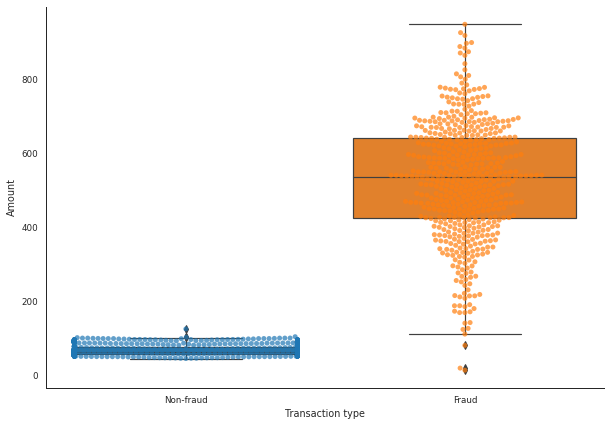

In [ ]:
# mean of amount of money for fraud and non-fraud transactions
amt_cc_sum = df_train.groupby(["cc_num", "is_fraud"])[
    "amt"].mean().sort_values(ascending=False).reset_index()

# plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.swarmplot(x="is_fraud", y="amt", data=amt_cc_sum, alpha=0.7, ax=ax)
sns.boxplot(x="is_fraud", y="amt", data=amt_cc_sum, ax=ax)
ax.set_ylabel("Amount")
ax.set_xlabel("Transaction type")
ax.set_xticklabels(["Non-fraud", "Fraud"])
sns.despine()

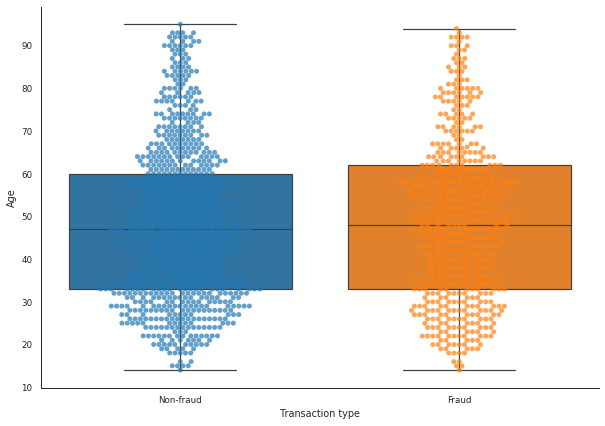

In [ ]:
# mean of age of cardhodlers for fraud and non-fraud transactions
amt_age_mean = df_train.groupby(["cc_num", "is_fraud"])[
    "age"].mean().sort_values(ascending=False).reset_index()

# plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.swarmplot(x="is_fraud", y="age", data=amt_age_mean, alpha=0.7, ax=ax)
sns.boxplot(x="is_fraud", y="age", data=amt_age_mean, ax=ax)
ax.set_ylabel("Age")
ax.set_xlabel("Transaction type")
ax.set_xticklabels(["Non-fraud", "Fraud"])
sns.despine()

### Are fraud transactions more frequent in a specific type of merchant, gender or age group?

In the first column of stacked barplots I have plotted the 'number of transactions' splitted by fraud (1) and non-fraud (0):

* I can see that the highest number of fraud transactions are located in grocery, while for shopping, other online transactions and even gas transport the number of fraud transactions are smaller but higher than the other categories.


* The number of fraud transactions seems to affect more to women than men, so this will be a useful feature during classification.


* Moreover, fraud transactions also affect more to people over 30 years old. In the pie plot of the percentage of fraud transactions, all cohorts share the same pattern of fraud transactions. Although, for people aged more than 50 years old the predominant category for fraud transactions of grocery, but for younger cohorts is online shooping. Hence, this interaction of age and category should also be considered.

In the second column of stacked barplots I have plotted the 'amount' of the transactions by fraud (1) and non-fraud (0):

* Also, the higher amounts for fraud transactions are found for shopping and other online transactions, but also for entertainment.


* Although the number of fraud transactions were found for women, the largest amount of money in fraud transactions affect men.


* Finally, the amount of money defrauded money is found for very young people below 20 years old or elderly people between 50 and 100 years old. On the other hand,people between 20 and 50 years old lower amounts of defrauded money in fraud transactions.

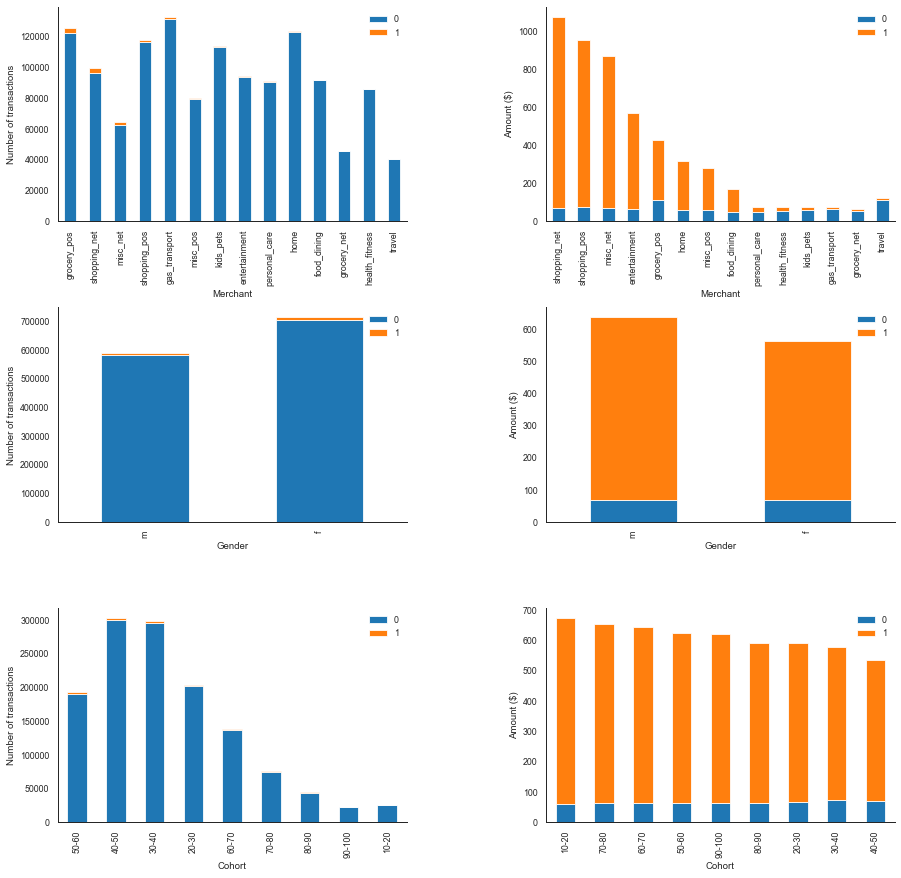

In [ ]:
# set a dictionary column name in the DataFrame as key and a list contianing plot row location and plot name as as value
plots = {"category": [0, "Merchant"], "gender": [1, "Gender"], "cohort": [2, "Cohort"]}
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

# plot
for plot_type, i in plots.items():
    pd.pivot_table(data=df_train[[plot_type,"is_fraud"]], 
                   index=plot_type, columns="is_fraud", 
                   aggfunc=np.count_nonzero).sort_values(by=1, ascending=False).plot(kind="bar", stacked=True, ax=ax[i[0], 0])
    pd.pivot_table(data=df_train, values="amt", 
                   index=plot_type, 
                   columns="is_fraud").sort_values(by=1, ascending=False).plot(kind="bar", stacked=True, ax=ax[i[0], 1])
    ax[i[0], 0].set_ylabel("Number of transactions")
    ax[i[0], 0].set_xlabel("{}".format(i[1]))
    ax[i[0], 0].tick_params(axis="x", rotation=90)
    ax[i[0], 0].legend(frameon=False)
    ax[i[0], 1].set_ylabel("Amount ($)")
    ax[i[0], 1].set_xlabel("{}".format(i[1]))
    ax[i[0], 1].tick_params(axis="x", rotation=90)
    ax[i[0], 1].legend(frameon=False)
    sns.despine()

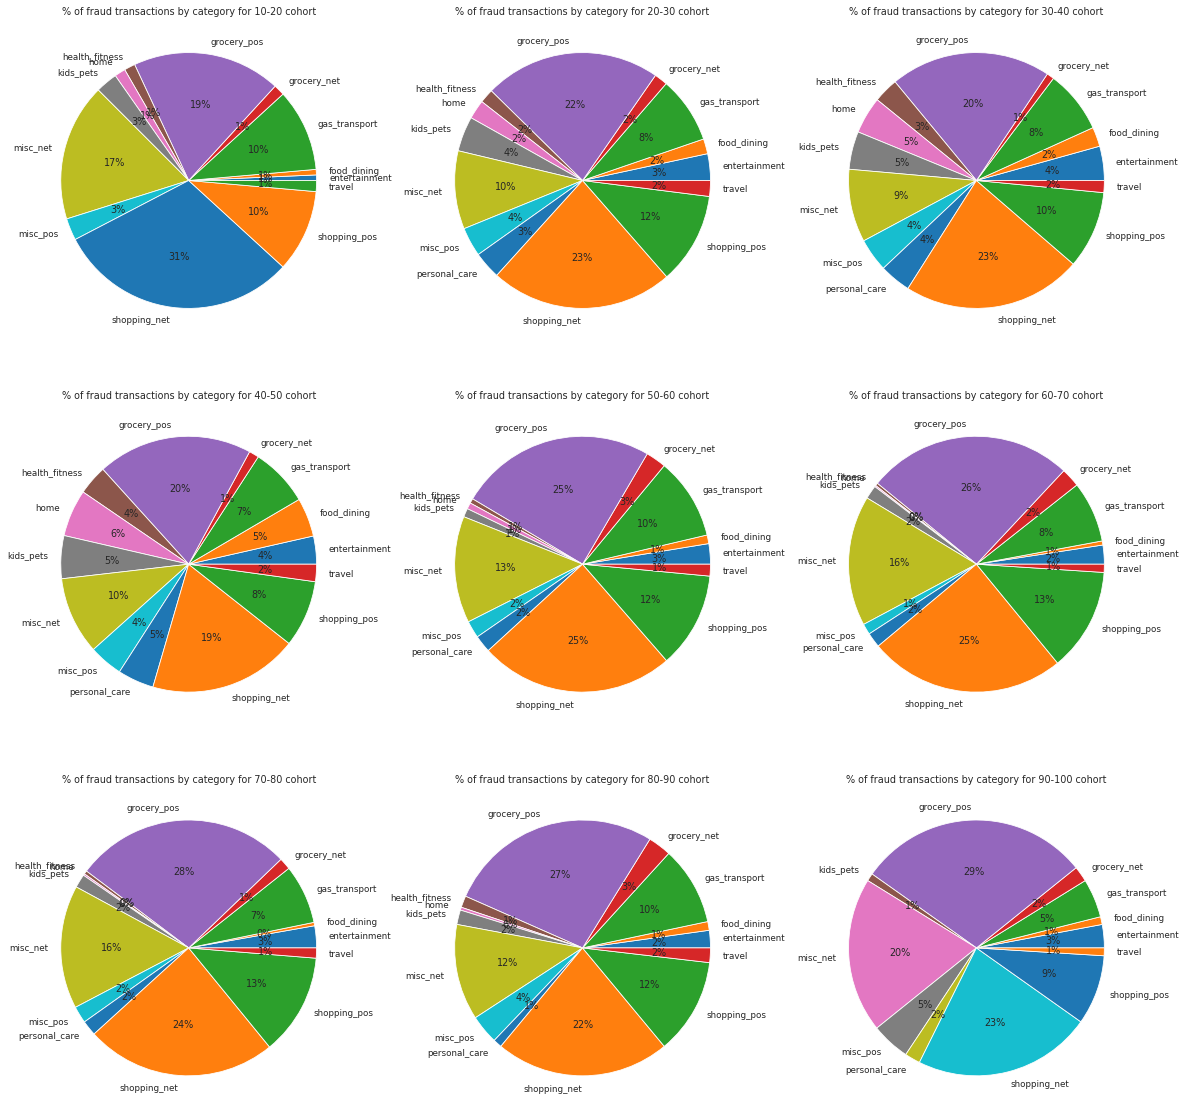

In [ ]:
# count the number of fraud transactions by age cohort and merchant category
int_age_cat = df_train[df_train["is_fraud"] == 1].groupby(["cohort", "category"])["is_fraud"].sum().reset_index()

# create subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

list_age = list(int_age_cat["cohort"].unique())

# plot
for i in range(len(list_age)):
    if i <= 2:
        row, col = 0, i
    elif (i > 2) & (i <= 5):
        row, col = 1, i-3
    else:
        row, col = 2, i-6
    df = int_age_cat[int_age_cat["cohort"] == list_age[i]]
    ax[row, col].pie(x=df["is_fraud"], 
                     labels=df["category"], 
                     autopct="%.0f%%")
    ax[row, col].set_title("% of fraud transactions by category for {} cohort".format(list_age[i]))

### Fraud transactions: is there an association between amount, age and city population?

I see in the scatter plot that no linear correlation is found between these variables for fraud transactions.

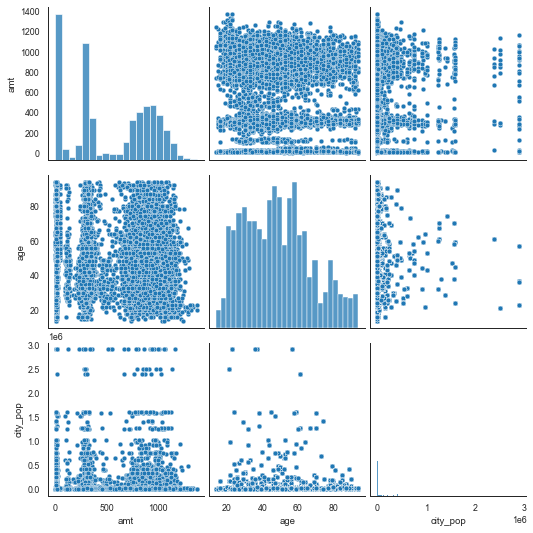

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,7506,0.04144,"[0.02, 0.06]",0.001717,0.001451,0.000329,9.126,0.948646


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,7506,0.021916,"[-0.0, 0.04]",0.00048,0.000214,0.057607,0.088,0.47567


In [ ]:
# create pairplot for fraud transactions with amount, age and city population
sns.pairplot(data=df_train[df_train["is_fraud"] == 1], vars=["amt", "age", "city_pop"])
plt.show()

# display correlation between amount and age for fraud transactions
display(pg.corr(x=df_train[df_train["is_fraud"] == 1]["amt"], y=df_train[df_train["is_fraud"] == 1]["age"]))

# display correlation between amount and city population for fraud transactions
display(pg.corr(x=df_train[df_train["is_fraud"] == 1]["amt"], y=df_train[df_train["is_fraud"] == 1]["city_pop"]))

### Plot location of fraud and non-fraud transactions based on the amount defrauded.

As all rows containing the same city have the same latitude and longitude, I can group our DataFrame by city and compute the mean of latitude, longitude and amount of money used in the transaction.

Fraud transactions are equally spread all over the United States. However, more fraud transactions are found in the most populated areas in the east and west coasts.

If I limit this to fraud transactions above the mean+1.5xSD, the highest amounts for fraud transactions are found in the east coast, so location of the merchant should be a useful feature.

In [ ]:
def plot_map_transactions(df, target_variable):
    
    """
    Plot a map with the location of the transactions based on latitude and
    longitude. Uses radius feature to plot the size of the circles based on
    the amount of money.
    
    Input:
        df (DataFrame): DataFrame containing all the useful features for the plot
        color (str): color in which the circles should be ploted. Default set to
                     blue
    Output:
        map_US (map): Folium object that plots the map.
    """
    
    map_US = folium.Map(location=[40.13909539078333, -102.08897877194904],
                     zoom_start=4,
                     tiles="cartodbpositron")
    
    df = df.reset_index(drop=True)
    
    data = []
    for index, row in df.iterrows():
        data.append([row["lat"], row["long"], row[target_variable]])
       
    HeatMap(data=data,
            radius = 20, 
            min_opacity = 0.3, 
            max_val=df[target_variable].max(),
            gradient={"0":"Navy", "0.25":"Blue","0.5":"Green", "0.75":"Yellow","1": "Red"}).add_to(map_US)
    
    return map_US

#### Plot: mean count of fraud transactions by city

In [ ]:
# latitude and longitude for each city
temp_lat_long_city =  df_train.groupby(["city"])[["lat", "long"]].mean().reset_index()

# percentage of fraud transactions (fraud transactions/all transactions) for each city
temp_perc_fraud_city = ((df_train[df_train["is_fraud"] == 1].groupby(["city"])["is_fraud"].count() / 
             df_train.groupby(["city"])["is_fraud"].count())*100).reset_index()

# merge percentage of fraud transactions and city latitude and longitude
temp_perc_fraud_city = temp_perc_fraud_city.merge(temp_lat_long_city, how="inner", left_on="city", right_on="city")

# compute radius for each city based on the percentage of fraud transactions in each
temp_perc_fraud_city["radius"] = temp_perc_fraud_city["is_fraud"]/50

# drop cities with no fraud transactions
temp_perc_fraud_city.dropna(inplace=True)

# plot
plot_map_transactions(temp_perc_fraud_city, target_variable="is_fraud")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.


#### Plot: mean count of fraud transactions by state

In [ ]:
# latitude and longitude for each state
temp_lat_long_state =  df_train.groupby(["state"])[["lat", "long"]].mean().reset_index()

# percentage of fraud transactions (fraud transactions/all transactions) by state
temp_perc_fraud_state = ((df_train[df_train["is_fraud"] == 1].groupby(["state"])["is_fraud"].count() / 
             df_train.groupby(["state"])["is_fraud"].count())*100).reset_index()

# merge percentage of fraud transactions and state latitude and longitude
temp_perc_fraud_state = temp_perc_fraud_state.merge(temp_lat_long_state, how="inner", left_on="state", right_on="state")

# compute radius for each state based on the percentage of fraud transactions in each
temp_perc_fraud_state["radius"] = temp_perc_fraud_state["is_fraud"]/50

# drop states with no fraud transactions
temp_perc_fraud_state.dropna(inplace=True)

# plot
plot_map_transactions(temp_perc_fraud_state, target_variable="is_fraud")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.


#### Plot: mean amount of money defrauded by city

In [ ]:
# latitude and longitude for each city and mean amount of money defrauded for each city
df_city_amt_fraud = df_train[df_train["is_fraud"] == 1].groupby(["city"])[
    ["lat", "long", "amt"]].mean().reset_index().set_index("city")

# compute radius based on the amount for fraud transactions
df_city_amt_fraud["radius"] = df_city_amt_fraud["amt"]/50

# plot
plot_map_transactions(df_city_amt_fraud, target_variable="amt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.


In [ ]:
# latitude and longitude for each city and mean amount of money defrauded by state
df_state_amt_fraud = df_train[df_train["is_fraud"] == 1].groupby(["state"])[
    ["lat", "long", "amt"]].mean().reset_index().set_index("state")

# compute radius based on the amount for fraud transactions
df_state_amt_fraud["radius"] = df_state_amt_fraud["amt"]/50

# plot
plot_map_transactions(df_state_amt_fraud, target_variable="amt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.


### Are some states or cities that have a high percentage of this type of transactions?

Interestingly, Delaware (DE) state has all of its transactions labelled as fraud, while for the rest of the states fraud transactions represent a small percentage of all transactions.

Exploring this pattern by city, there are a high number of cities following the same pattern as the state of Delaware.

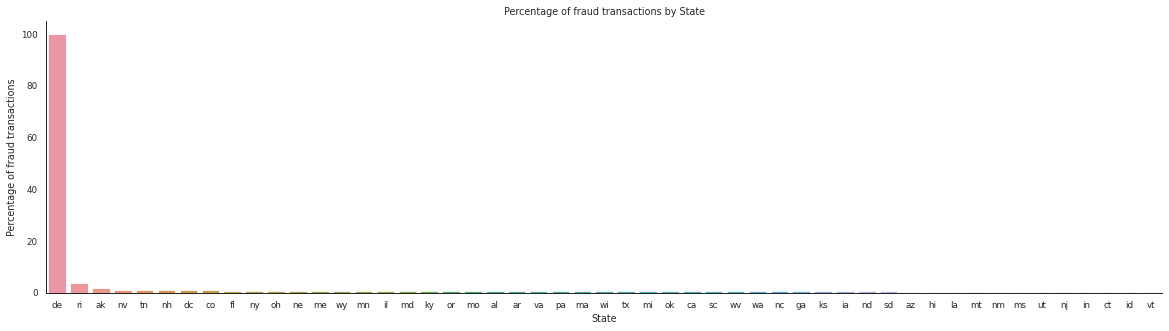

In [ ]:
# percentage of fraud transactions by state
temp = ((df_train[df_train["is_fraud"] == 1].groupby(["state"])["is_fraud"].count() / 
             df_train.groupby(["state"])["is_fraud"].count())*100).reset_index()

# sort values
temp.sort_values(by=["is_fraud"], ascending=False, inplace=True)

# plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x="state", y="is_fraud", data=temp)
plt.title("Percentage of fraud transactions by State")
plt.xlabel("State")
plt.ylabel("Percentage of fraud transactions")
sns.despine()

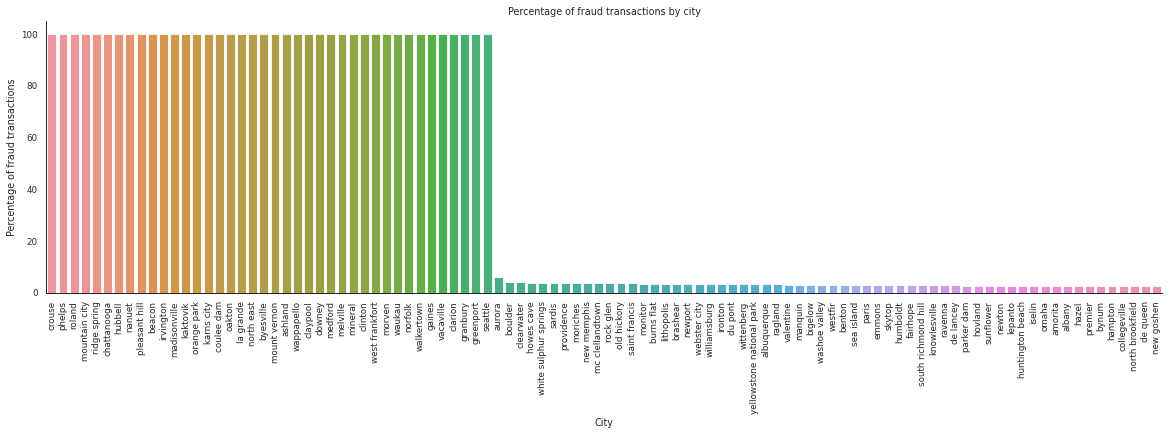

In [ ]:
# percentage of fraud transactions by city
temp = ((df_train[df_train["is_fraud"] == 1].groupby(["city"])["is_fraud"].count() / 
             df_train.groupby(["city"])["is_fraud"].count())*100).reset_index()

# sort values
temp.sort_values(by=["is_fraud"], ascending=False, inplace=True)

# plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x="city", y="is_fraud", data=temp.head(100))
plt.title("Percentage of fraud transactions by city")
plt.xlabel("City")
plt.ylabel("Percentage of fraud transactions")
plt.xticks(rotation=90)
sns.despine()

### Are there some jobs with a high percentage of fraud transactions?

Interestingly, the same pattern found for states and cities is replicated in some jobs. Some of them also have all they transactions labelled as fraud.

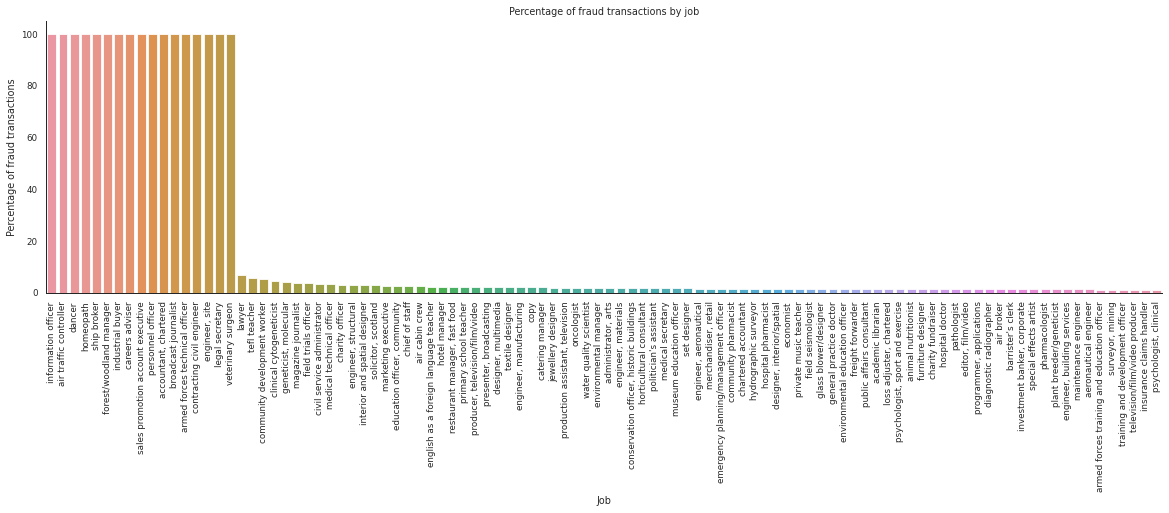

In [ ]:
# percentage of fraud transactions by job title
temp = ((df_train[df_train["is_fraud"] == 1].groupby(["job"])["is_fraud"].count() / 
             df_train.groupby(["job"])["is_fraud"].count())*100).reset_index()

# sort values
temp.sort_values(by=["is_fraud"], ascending=False, inplace=True)

# plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x="job", y="is_fraud", data=temp.head(100))
plt.title("Percentage of fraud transactions by job")
plt.xlabel("Job")
plt.ylabel("Percentage of fraud transactions")
plt.xticks(rotation=90)
sns.despine()

### Is this pattern also found by merchant zip code?

Also some merchant zip codes have all of their transactions labelled as fraud.

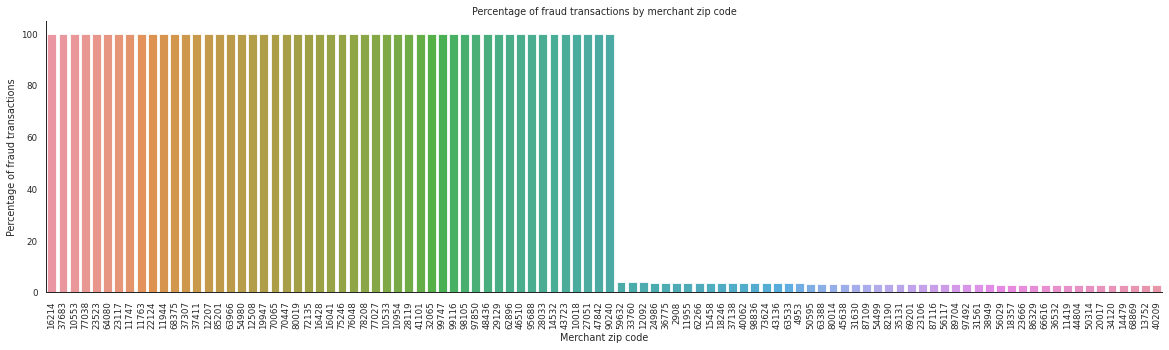

In [ ]:
# percentage of fraud transactions by zip code
temp = ((df_train[df_train["is_fraud"] == 1].groupby(["zip"])["is_fraud"].count() / 
             df_train.groupby(["zip"])["is_fraud"].count())*100).reset_index()

# set "zip" as string, otherwise when it is plotted seaborn will order ir in ascending order automatically
temp["zip"] = temp["zip"].astype("str")

# sort values
temp.sort_values(by=["is_fraud"], ascending=False, inplace=True)

# plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x="zip", y="is_fraud", data=temp.head(100))
plt.title("Percentage of fraud transactions by merchant zip code")
plt.xlabel("Merchant zip code")
plt.ylabel("Percentage of fraud transactions")
plt.xticks(rotation=90)
sns.despine()

### What time of the day are fraud transactions more frequent?

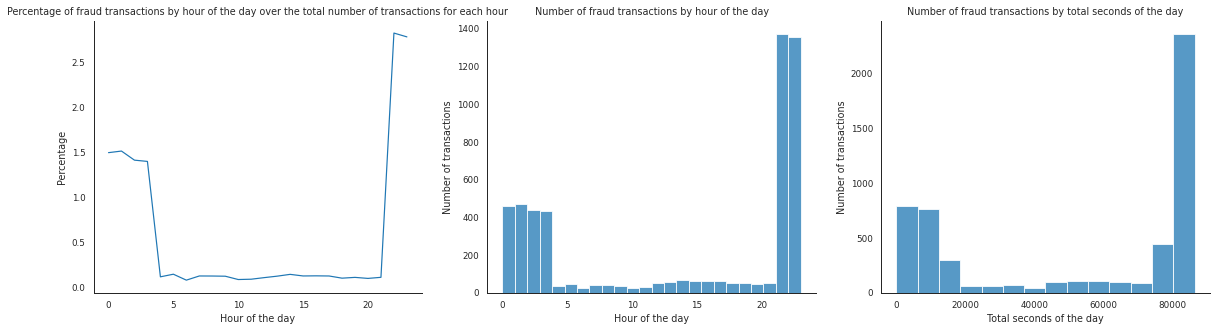

In [ ]:
# percentage of fraud transaction by hour of the day
temp = ((df_train[df_train["is_fraud"] == 1].groupby(
    df_train["trans_date_trans_time"].dt.hour)["is_fraud"].count() / 
    df_train.groupby(df_train["trans_date_trans_time"].dt.hour)["is_fraud"].count())*100).reset_index()

# fraud transactions
fraud = df_train[df_train["is_fraud"] == 1]

# plot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x="trans_date_trans_time", y= "is_fraud", data=temp, ax=ax[0]) # lineplot
sns.histplot(fraud["trans_date_trans_time"].dt.hour, bins=24, ax=ax[1]) # histogram
sns.histplot(fraud["total_seconds_day"], ax=ax[2]) # histogram
ax[0].set_title("Percentage of fraud transactions by hour of the day over the total number of transactions for each hour")
ax[0].set_xlabel("Hour of the day")
ax[0].set_ylabel("Percentage")
ax[1].set_title("Number of fraud transactions by hour of the day")
ax[1].set_xlabel("Hour of the day")
ax[1].set_ylabel("Number of transactions")
ax[2].set_title("Number of fraud transactions by total seconds of the day")
ax[2].set_xlabel("Total seconds of the day")
ax[2].set_ylabel("Number of transactions")
sns.despine()

### What day of the week are fraud transactions more frequent?

Fridays have a higher percentage of fraud transactions, although when looking at the count of fraud transactions, I see that Thursday, followed by Friday and Saturdays are the days of the week that present the highest number of this type of transactions.

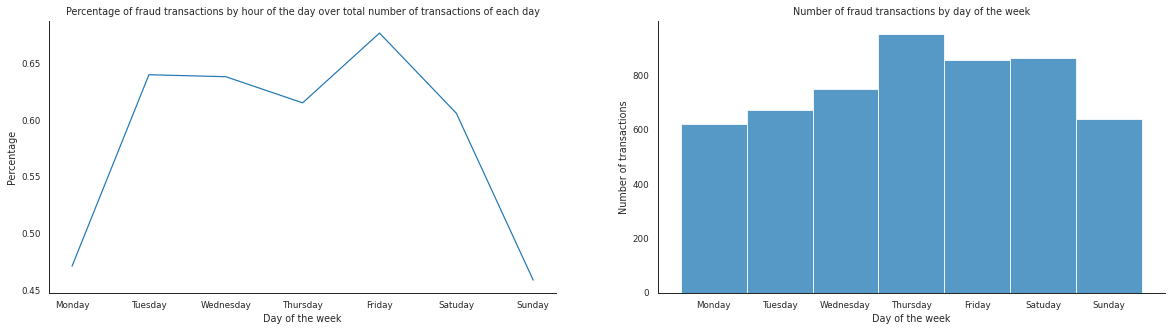

In [ ]:
# percentage of fraud transaction by day of the week
temp = ((df_train[df_train["is_fraud"] == 1].groupby(df_train["trans_date_trans_time"].dt.dayofweek)["is_fraud"].count() / 
             df_train.groupby(df_train["trans_date_trans_time"].dt.dayofweek)["is_fraud"].count())*100).reset_index()

temp["trans_date_trans_time"] = temp["trans_date_trans_time"].astype(str)

# fraud transactions
fraud = df_train[df_train["is_fraud"] == 1]

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x="trans_date_trans_time", y= "is_fraud", data=temp, ax=ax[0])
sns.histplot(fraud["trans_date_trans_time"].dt.dayofweek.astype(str), bins=7, ax=ax[1])
ax[0].set_title("Percentage of fraud transactions by hour of the day over total number of transactions of each day")
ax[0].set_ylabel("Percentage")
ax[1].set_title("Number of fraud transactions by day of the week")
ax[1].set_ylabel("Number of transactions")
for i in range(2):
    ax[i].set_xlabel("Day of the week")
    ax[i].set_xticklabels(labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Satuday", "Sunday"])
sns.despine()

### Is there a tendency to perform fraud transactions during a specific time of the year?

From the plots I can see that non-fraud transactions are high during the Christmas period, specially during December.

Similarly, at the same time Christmas purchases increase, so does fraud. These transactions are specially high during December and January. 

Surprisingly, fraud transactions are low during the summer months, although non-fraud transactions have another increase during this period, yet not as high compared to the Christimas period.

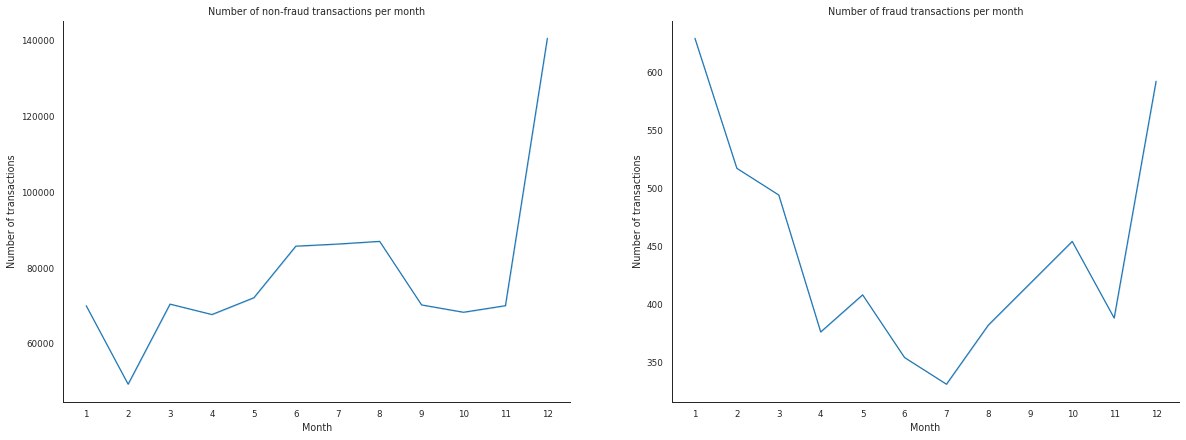

In [ ]:
# create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# dfs with fraud and non-fraud transactions
dfs = {0: df_train[df_train["is_fraud"] == 0], 
       1: df_train[df_train["is_fraud"] == 1]}

# iterate over the dictionary to plot number of transactions for each type for
# each month of the year
for i, df in dfs.items():
    if i == 0:
        title = "non-fraud"
    else:
        title = "fraud"
    
    sns.lineplot(data=df, 
                 x="month",
                 y="amt",
                 estimator=np.count_nonzero, # count non zeros values in amount column
                 ax=ax[i])
    ax[i].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # months
    ax[i].set_xlabel("Month")
    ax[i].set_ylabel("Number of transactions")
    ax[i].set_title("Number of {} transactions per month".format(title))
sns.despine()

### Is there a tendency for fraud and non-fraud transactions to be higher during a specific time of the year?

As expected, the highest amounts of money spent for non-fraud transactions during an entire year are found during the summer months and Christmas period.

The amount of money for fraud transactions show its highest peaks during July, October and December. This is interesting, as although during July the number of fraud transaction is the lowest of the year, I can see that the amount of money defrauded in that small amount of fraud transactions is quite high. Also, this amount of defrauded money during July seems not to differenciate much, in terms of mean amount of money, to the Christmas period.

* This suggests that although during July there are less fraud transactions, the amount of money defrauded by transaction is higher than in other months. 

* Similarly, although the amount of fraud transactions is high during Christmas, is seems that the amount of defrauded money by transaction is lower.

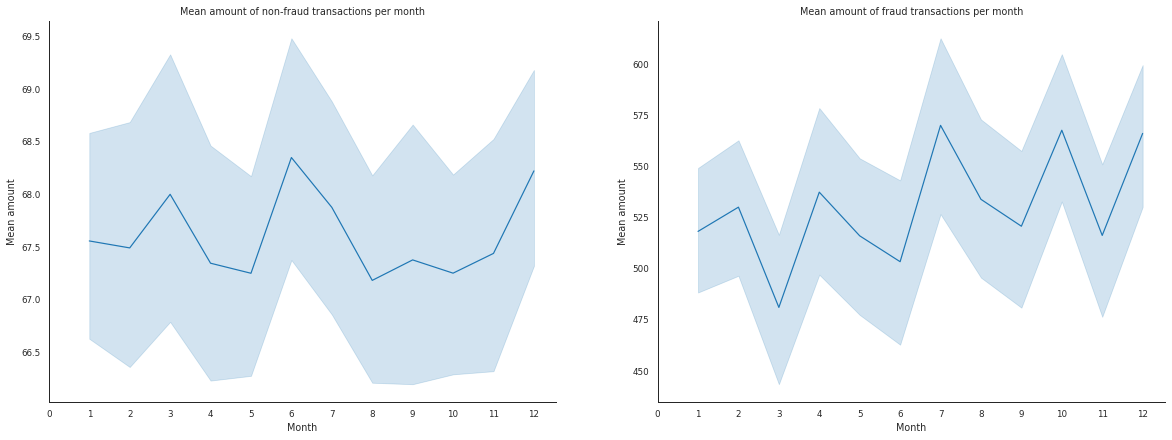

In [ ]:
# create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# dfs for fraud and non-fraud transactions
dfs = {0: df_train[df_train["is_fraud"] == 0], 
       1: df_train[df_train["is_fraud"] == 1]}

# plot
for i, df in dfs.items():
    if i == 0:
        title = "non-fraud"
    else:
        title = "fraud"
    
    sns.lineplot(data=df, 
                 x="month",
                 y="amt",
                 estimator=np.mean, # mean of amount
                 ax=ax[i])
    ax[i].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # months
    ax[i].set_xlabel("Month")
    ax[i].set_ylabel("Mean amount")
    ax[i].set_title("Mean amount of {} transactions per month".format(title))
sns.despine()

### Which merchant shows the higher number of fraud transactions?

In the first plot I see that one merchant has the largest number of fraud transactions, and up to six merchants also show a high number of fraud transactions.

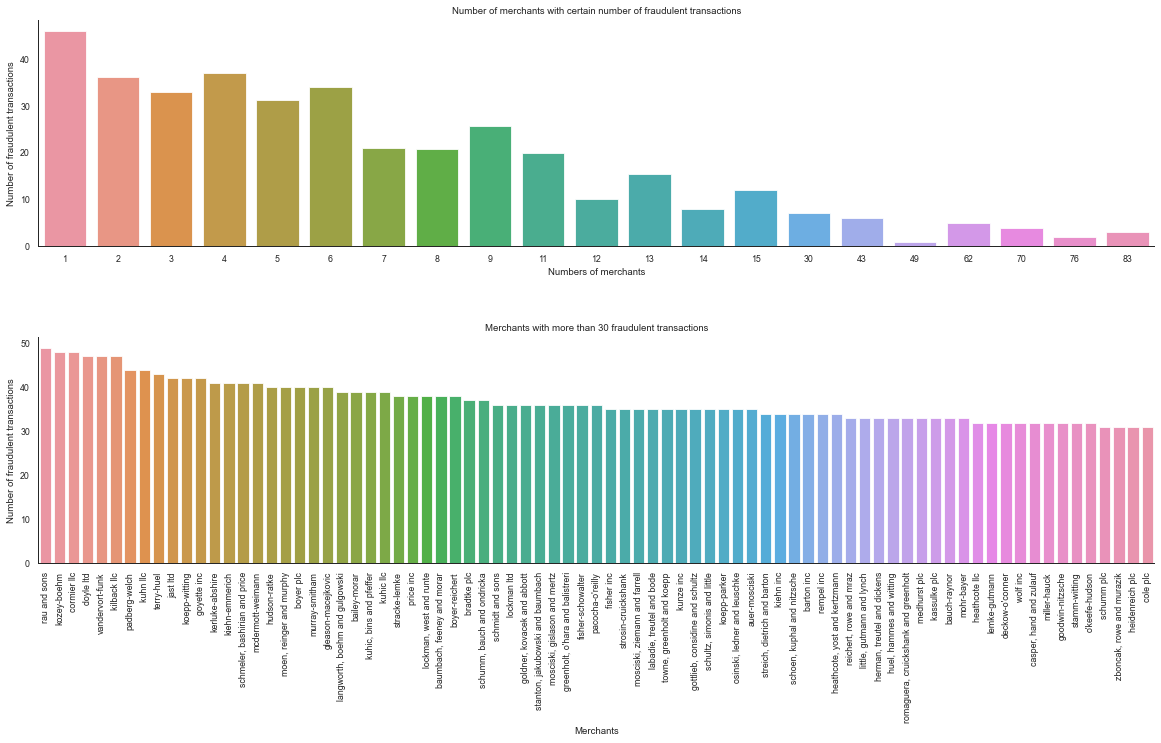

In [ ]:
# keep fraud transactions
df_fraud = df_train[df_train["is_fraud"] == 1]

# count the number of fraud transactons by merchant
count_fraud_merchant_1 = df_fraud.groupby(["merchant"])["is_fraud"].apply(np.count_nonzero).sort_values(
    ascending=False).reset_index()

# count the number of merchants that show a certain number of fraud transactions
count_fraud_merchant_2 = count_fraud_merchant_1.groupby(["is_fraud"])["merchant"].apply(
    np.count_nonzero).reset_index().sort_values(by="is_fraud", ascending=False)

# plot
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)
sns.barplot(data=count_fraud_merchant_2, x="merchant", y="is_fraud", ci=None, ax=ax[0])
sns.barplot(data=count_fraud_merchant_1[count_fraud_merchant_1["is_fraud"] > 30], 
            x="merchant", y="is_fraud", ci=None, ax=ax[1])
ax[0].set_title("Number of merchants with certain number of fraud transactions")
ax[1].set_title("Merchants with more than 30 fraud transactions")
ax[0].set_xlabel("Numbers of merchants")
ax[1].set_xlabel("Merchants")
ax[0].set_ylabel("Number of fraud transactions")
ax[1].set_ylabel("Number of fraud transactions")
ax[1].tick_params(axis="x", rotation=90)
sns.despine()

### Which merchant category shows the higher number of fraud transactions?

The plot reveals that the higher number of fraud transactions are found for groceries and online purchases.

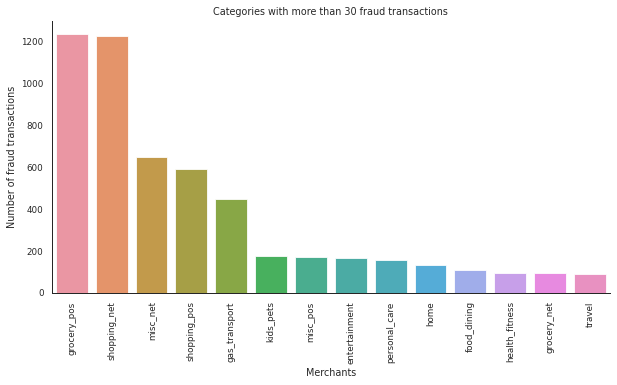

In [ ]:
# keep fraud transactions
df_fraud = df_train[df_train["is_fraud"] == 1]

# count the number of fraud transactions by merchant category
count_fraud_category = df_fraud.groupby(["category"])["is_fraud"].apply(np.count_nonzero).sort_values(
    ascending=False).reset_index()

# plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)
sns.barplot(data=count_fraud_category[count_fraud_category["is_fraud"] > 30], 
            x="category", y="is_fraud", ci=None)
plt.title("Categories with more than 30 fraud transactions")
plt.xlabel("Merchants")
plt.ylabel("Number of fraud transactions")
plt.tick_params(axis="x", rotation=90)
sns.despine()

### How are fraud transactions distributed across cities population?

After binarizing city population into 20 bins (in order to reduce the number of bars in the plot), cities with a low number of inhabitants are the ones that show the highest number of fraud transactions.

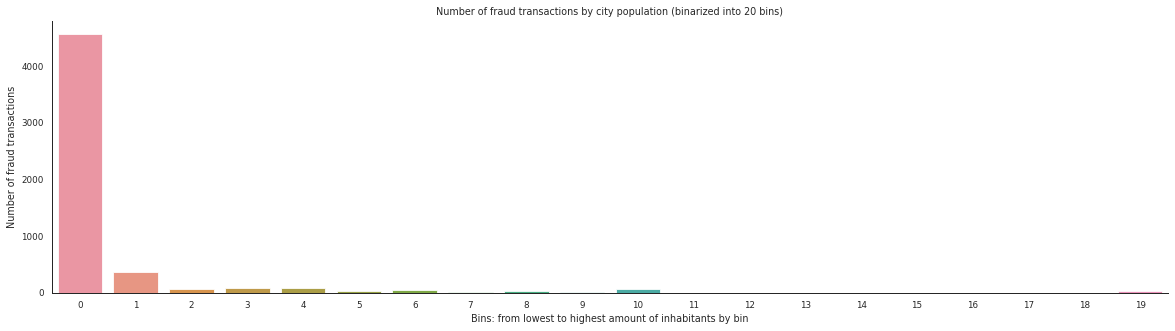

In [ ]:
# keep fraud transactions
temp = df_train[df_train["is_fraud"] == 1]

# count the number fo fraud transactions by city population: I get 505
# groups of city population, from 37 inhabitants to 2906700
temp = temp.groupby(["city_pop"]).count().reset_index()

# binarize city population into 20 bins. This df gives us the bin that each
# city population group belongs to
bins = pd.cut(x=temp["city_pop"], bins=20).reset_index()

# merge city population ground with its bins
temp = temp.merge(bins, how="inner", left_index=True, right_index=True)

# group by bin ('city_pop_y) and count the number of fraud transaction by bin
temp = temp.groupby(["city_pop_y"])["is_fraud"].sum().reset_index()

# plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=temp.index, y=temp["is_fraud"])
plt.title("Number of fraud transactions by city population (binarized into 20 bins)")
plt.xlabel("Bins: from lowest to highest amount of inhabitants by bin")
plt.ylabel("Number of fraud transactions")
sns.despine()

# Conclusion

In this notebook I have perfomed an exploratory analysis of the dataset. I have made some basic preprocessing steps to remove information and transform the useful one.

The dataset has been splitted into train, test and validation sets and saved for later usage in XGBoost, LightGBM and MLP models.

I have also identified important variables that should be retained, as cardholders' age and gender, state, city, city population, merchant category, hour of the day, month, zip code, etc.

Although some variables as job or merchant could be useful, they would lead to a high dimensionality of the dataset if they are not properly transformed, for example using Embeddings instead of One-Hot Encoding or Dummy Encoding. 

In the next notebook I will perform some feature engineering to create new features based on the ones present in the original dataset.